In [1]:
from functional import *
from transformer_core import multihead_attention,encoder
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
plt.rc('figure',titleweight='bold',titlesize='large',figsize=(15,6))
plt.rc('axes',titleweight='bold',titlesize='large',labelweight='bold',labelsize='large',grid=True)

2024-09-25 23:10:20.230885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 23:10:20.241934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 23:10:20.246071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 23:10:20.255005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 23:10:20.957998: W tensorflow/compiler/tf2

In [2]:
class transfer_learning(funtional):
    def __init__(self,timeframe):
        self.timeframe=timeframe
        with open(os.path.join(Path().cwd(),'parameter.json'),'r') as f:
            params=json.load(f)
            self.symbol=params['symbol']
            self.test_size=params['test_size']
            self.ma_length=params['ma_length']
            self.price_type=params['price_type']
            self.seq_length=params['seq_length']
        self.pretrained_transformer=tf.keras.models.load_model(os.path.join(Path().cwd(),f'models/transformer_{self.price_type}_{self.symbol}_1d.keras'),custom_objects={'multihead_attention':multihead_attention,'encoder':encoder})
        self.pretrained_transformer.trainable=False

        self.df=pd.read_csv(os.path.join(Path().cwd(),f'data/{self.symbol}/{self.symbol}_{self.timeframe}.csv'),index_col=0,parse_dates=True)
        self.df['price']=self.df['Close']
        self.df['log']=np.log(self.df['Close'])
        self.df['moving_average']=self.df['price'].rolling(self.ma_length).mean()
        self.df['diff']=(self.df['price']-self.df['moving_average']).dropna()
        self.df.dropna(inplace=True)        

        self.x,self.y=[],[]
        # model_pred=pd.Series(self.model_selection[name].predict(self.x).reshape(-1),index=self.df.index[self.seq_length+1:])
        for i in range(len(self.df[self.price_type])-self.seq_length-1):
            self.x.append(self.df[self.price_type].iloc[i:i+self.seq_length].tolist())
            self.y.append(self.df[self.price_type].iloc[i+self.seq_length]) 
        self.x,self.y=np.array(self.x),np.array(self.y)

        index=int(self.x.shape[0]*(1-self.test_size))
        self.x_train=self.x[:index]
        self.y_train=self.y[:index]
        self.x_test=self.x[index:]
        self.y_test=self.y[index:]

    def sape(self,true_value,predict_value):
        average_volatility=pd.Series(true_value).pct_change().abs().mean()
        mape=mean_absolute_percentage_error(true_value,predict_value)
        scaled_perentage_error=mape/average_volatility
        return scaled_perentage_error

    def predict(self,true_value,predict_value):
        self.methods={'mae':mean_absolute_error,'mape':mean_absolute_percentage_error,'sape':self.sape}
        metrics,method_name=[],[]
        for name,method in self.methods.items():
            metrics.append(method(true_value,predict_value))
            method_name.append(name)
        return pd.Series(metrics,index=method_name)

    def compare(self):
        model_predict=self.model.predict(self.x).reshape(-1)
        self.predict(self.y,model_predict)
        return self.predict(self.y,model_predict)

    def build(self,epochs=10,optimizer='adam',loss='mae',activation='leaky_relu',batch_size=32):

        self.model=tf.keras.Sequential([
            tf.keras.layers.Input((self.seq_length,1)),
            self.pretrained_transformer,
            tf.keras.layers.Dense(100,activation=activation),
            tf.keras.layers.Dense(50,activation=activation),
            tf.keras.layers.Dense(20,activation=activation),
            tf.keras.layers.Dense(10,activation=activation),
            tf.keras.layers.Dense(5,activation=activation),
            tf.keras.layers.Dense(1)
        ])
        self.model.compile(optimizer=optimizer,loss=loss)
        best_lost=tf.keras.callbacks.ModelCheckpoint(os.path.join(Path().cwd(),f'models/transfer_{self.price_type}_{self.symbol}_{self.timeframe}.keras'),monitor='loss',mode='min',save_best_only=True)
        self.history=self.model.fit(self.x_train,self.y_train,epochs=epochs,batch_size=batch_size,callbacks=[best_lost],validation_data=(self.x_test,self.y_test))
        self.pred=self.model.predict(self.x)
        

In [3]:
timeframe='4h'
model=transfer_learning(timeframe=timeframe)

/py_virtual/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-09-25 23:10:22.756289: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


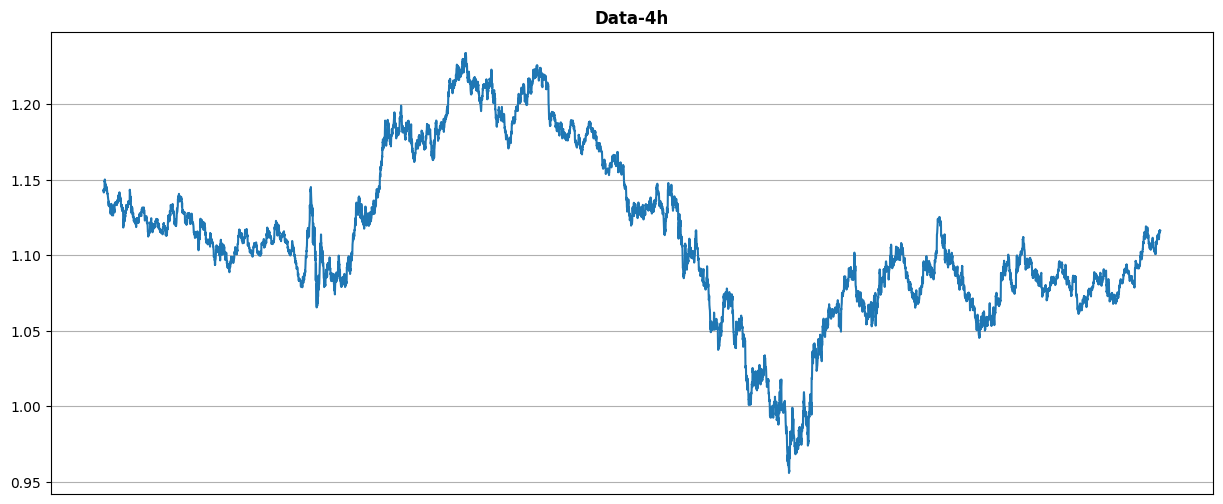

In [4]:
model.plot_data()

In [5]:
model.build(epochs=10,loss='mse')

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


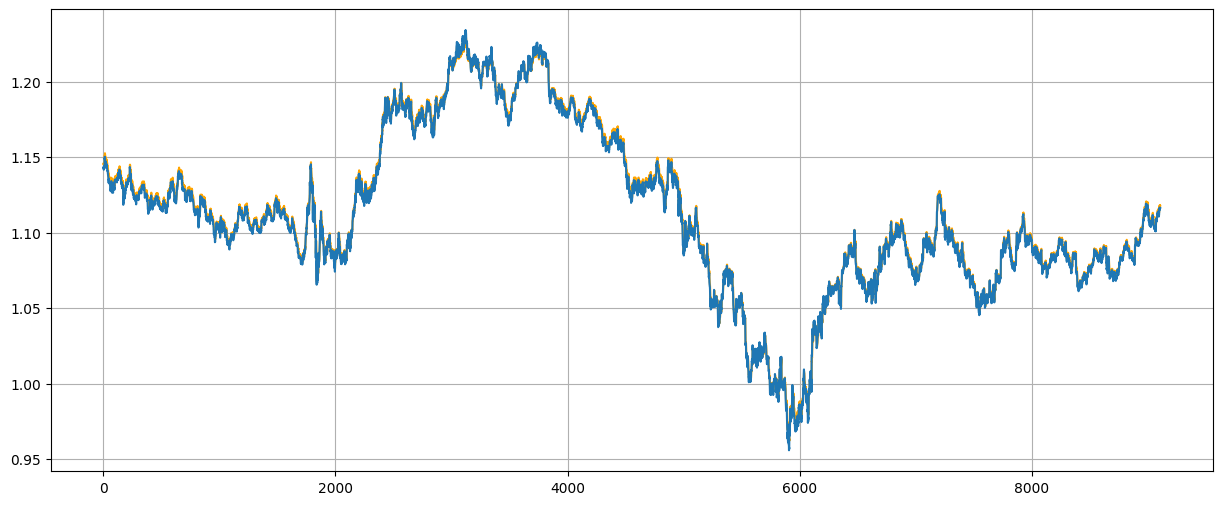

In [6]:
fg=plt.figure()
ax=fg.add_subplot()
ax.plot(model.pred,label='TRANSFER',color='orange')
ax.plot(model.y)

In [7]:
model.compare()

285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


mae     0.002158
mape    0.001948
sape    1.639402
dtype: float64